<p style="font-size: 26px; font-weight:bold" id="tocheading">Table of Contents</p>
<br><br>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

One of the core idea behind this project is to analyse the number of deaths for male and female due to road traffic accidents in Finland. Despite the fact that the regulations are very strict and the safety of the roads in the whole country is at a very high standard, there are still accidents happening. We are interested in the number of male/female deaths due to road traffic accident, how the number has changed from year to year and what are the pedictions for 2018.

We will start by exploring the data, polishing it and extracting needed information into a single file for our analysis. We will then move to methods learned in Bayesian Data Analysis course and create two models using Stan/Python that will predict the number of male/female deaths due to road traffic accident in Findland in 2018. 

Our project report will go in depth with data analysis, pooled/seperate models, convergence diagnostics for both models, model evaluations as well as model comparision.

We will end the report with a conclusion of which model was better and what are the predictions for 2018.

# Data

The data used in this project is taken from www.opendata.fi (Tieliikenneonnettomuudet). It includes an extensive records and various mesurments about road traffic accidents in Finland from 2005 to 2017. For instance, the data for 2005 looks like this:

In [2]:
import pandas as pd

data_2005 = pd.read_csv('data/tieliikenneonnettomuudet_2005_hlo.csv', sep=';', encoding = "ISO-8859-1")
data_2005.head(11)

,Onnett_id,Osall_id,Henkilo_id,Osnro,Kulj_matk,Ikä,Sukupuoli,Kortti,Seuraus,Seuraussel,Kulj_kans,Ajokortlk,Ajokortikä
0,6551782,11677943,11520814,1,KU,20.0,N,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
1,6551782,11677944,11520815,2,KU,24.0,M,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
2,6580617,11677952,11520824,1,KU,78.0,M,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
3,6580617,11677953,11520825,2,MA,59.0,M,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
4,6580617,11677953,11520826,2,KU,55.0,M,NaN,L,loukkaantunut,NaN,NaN,NaN
5,6571962,11677972,11521122,1,KU,18.0,M,X,0,ei henkilövahinkoa,NaN,NaN,NaN
6,6571962,11677973,11521123,2,KU,NaN,NaN,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
7,6673527,11677994,11521146,1,KU,44.0,M,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
8,6673527,11677995,11521147,2,KU,NaN,NaN,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN
9,6565101,11678000,11521152,1,MA,9.0,N,NaN,0,ei henkilövahinkoa,NaN,NaN,NaN


The [description of the data](https://www.opendata.fi/data/en_GB/dataset/tieliikenneonnettomuudet/resource/e5a9dcc6-aa65-4352-8ab6-5dc87cd1e61d) is stated by www.opendata.fi. The information that we are mainly intrerested is `Seuraussel` (Consequence) and `Sukupuoli` (Gender). 

The `Seuraussel` (Consequence) is classified into:

* 0 - ei henkilövahinkoa (No injuries) 
* L - loukkaantunut (Injured)
* K - kuollut (died)

`Sukupuoli` (Gender) has:
* M – Mies (Male)
* N – Nainen (Female)
* '' - Ei tietoa (No information)

## Data preprocessing

To clean the data and extract the information that is needed in our project we had go through each year, read the `Seuraussel` (Consequnces) and filter it by `kuollut` (died). After that, we exported that information into `data.csv`. Here is the python code for that:

In [3]:
import numpy as np

def process_data():    
    data_years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    for year in data_years:
        data = pd.read_csv(
            'data/project/csv/tieliikenneonnettomuudet_{0}_hlo.csv'.format(year), 
            sep=';', 
            encoding = "ISO-8859-1"
        )

        death = data.loc[data['Seuraussel'] == 'kuollut']
        gender = death['Sukupuoli'].values

        male = np.count_nonzero(gender == 'M')
        female = np.count_nonzero(gender == 'N')

        data = {'year': [year], 'male': [male], 'female': [female]}
        df = pd.DataFrame(data)

        df = df[['year', 'male', 'female']]
        df.to_csv('data/data.csv', mode='a', header=None, index=False)

# process_data()

To check quickly check how our data looks like after export, we can print it with `pandas`:

In [4]:
data = pd.read_csv('data/data.csv', sep = ',')
data

,year,male,female
0,2005,217,72
1,2006,186,65
2,2007,211,75
3,2008,173,50
4,2009,203,67
5,2010,204,68
6,2011,210,81
7,2012,191,63
8,2013,189,65
9,2014,165,61


The `male` and `female` columns stands for the number of death for male and female respectively, in a spicefied year. 

## Data analysis

### Number of death due to road traffic accidents in Finland

In this section we are interested in having a quick look at the data. Plotting the trends both for male and female deaths will give us an insight how rate is changing from year to year and what would be the expectations for the future.

In [5]:
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

We can define a python function `plot_trend` and reuse it for male and felmale data:

In [6]:
def plot_trend(x_axis, y_axis, tlitle=''):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2004, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.title(tlitle)
    plt.show()

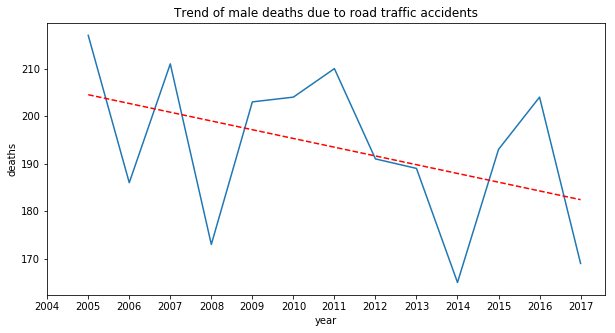

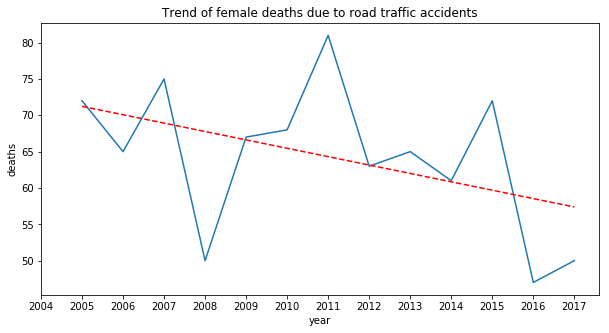

In [31]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 2018

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
N = len(total_deaths) * 2
num_groups = 2
x = np.arange(1, 3)
x = np.repeat(x, len(years))
group_indicator = np.arange(1, 3)
group_indicator = np.repeat(x, len(years))
combined = np.concatenate((male, female), axis=0)
plot_trend(years, male, 'Trend of male deaths due to road traffic accidents')
plot_trend(years, female, 'Trend of female deaths due to road traffic accidents')

## Prior calculations

We would like to apply a weakly-informative prior $N(0, \tau^{2})$ for the slope parameter $\beta$. It is very unlikely that the mean number of deaths changes more than 50% in one year. The approximate historical mean yearly for the number of total number deaths is $257.76$. Hence, we have to set $\tau$ so that the prior probability for $\beta$ being less than $−128.88$ or greater than $128.88$ is 0.01. Consequently, we have to calculate $\tau$ for *total number of deaths*, *male deaths* and *female deaths*.

#### Tau calculation for total death

In [8]:
# The value of dist.cdf(−128.9) should be 0.1/2 for the correct τ .
# mu = 257.8 => 257.8/2 = 128.9
from scipy.stats import norm
print(mu)
print(mu/2)

taus = []
for tau in np.arange(78, 79, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-128.9)
    if val <= 0.050002 and val >= 0.049998:
        taus.append(tau)
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
total_deaths_tau = taus[0]
print('total_deaths_tau', total_deaths_tau)

257.7692307692308
128.8846153846154
tau:   	 78.36500000000174
val: 	 0.04999862400818712 

tau:   	 78.36600000000175
val: 	 0.05000078876859009 

total_deaths_tau 78.36500000000174


#### Tau calculation for male death

In [9]:
mu_male = np.mean(male)
print(mu_male)
print(mu_male/2)

taus = []
for tau in np.arange(58.5, 59, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-96.73)
    if val <= 0.050002 and val >= 0.049998:
        taus.append(tau)
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
# male tau: 58.8069

male_tau = taus[0]
print('male_tau', male_tau)

193.46153846153845
96.73076923076923
tau:   	 58.806999999999285
val: 	 0.0499980835484519 

tau:   	 58.80799999999928
val: 	 0.05000096825233351 

male_tau 58.806999999999285


####  Tau calculation for female death

In [10]:
mu_female = np.mean(female)
print('mu_female', mu_female)
print('dev/2', mu_female/2)

taus = []
for tau in np.arange(19, 20, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-32.15)
    if val <= 0.05001 and val >= 0.04999:
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
        taus.append(tau)
female_tau = taus[0]
print('female_tau', female_tau)

mu_female 64.3076923076923
dev/2 32.15384615384615
tau:   	 19.545000000000666
val: 	 0.04999295128373794 

tau:   	 19.546000000000667
val: 	 0.05000163043808533 

female_tau 19.545000000000666


# Models

## Pooled Model

In the pooled model all the data is considered as one entity. Thus, we have to combine the male and female data into one and perform our prediction on it. Even though, that won't give us an explicit number of death for female and male, we can still check the trend of the total number of deaths.

Our model takes these parameters:
* *N*: Total number of deaths 
* *xpred*: the year we wont to predict
* *number_of_deaths*: number of deaths passed as an array
* *years*: list of the years passed as an array
* *tau*: $\tau$ is used for weekly informative prior like: `beta ~ normal(0, tau)`. If we don't include it then our prior would be uniform.

We then transform $\mu$ as we are using regression and our value must be $\alpha + \beta * years$. Further we predict the number of death for the future by creating `new_pred` and assigning to it `normal_rng(alpha + beta * xpred, sigma)`. The `log_lik` value is later used for evaluation of the model.

In [11]:
# POOLED MODEL
pooled_code = '''
data {
    int<lower=0> N;                 // number of data points
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
    real tau;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = alpha + (beta * years);
    
}

model {
    beta ~ normal(0, tau);
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma);
}

generated quantities {
    real new_pred;
    vector[N] log_lik;
    
    new_pred = normal_rng(alpha + beta * xpred, sigma);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma);
}
'''

sm = pystan.StanModel(model_code = pooled_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1784aba4ea0a680e9585d84ebbc55d57 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmpfo6xg77m/stanfit4anon_model_1784aba4ea0a680e9585d84ebbc55d57_1535615306375866876.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Pooled model to predict the total number of deaths due to road traffic accidents

In [12]:
accidents_data = {
    'N': len(total_deaths),
    'number_of_deaths': total_deaths,
    'years': years,
    'xpred': 2018,
    'tau': total_deaths_tau
}

In [13]:
pooled_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

### How Stan code is run

The Stan code for the pooled model is configured to use <b>4 chains</b>.
<br>
Each of those chains has <b>2000 iterations</b>.
<br>
<b>1000 samples</b> are discarded as a burnout.
<br><br>
In order to control the sampler's behavior, we have set: <b>'adapt_delta': 0.95</b> and <b>'max_treedepth': 15</b>

### Model summary

In [14]:
def get_model_summary(model_fit):
    summary = model_fit.summary()
    summary = pd.DataFrame(
        summary['summary'], 
        columns=summary['summary_colnames'], 
        index=summary['summary_rownames']
    )

    log_lik = model_fit.extract(permuted=True)['log_lik']

    loo, loos, ks = psisloo(log_lik)
    print('PSIS-LOO value: {0}'.format(loo))

    S = np.shape(log_lik)[0]
    lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

    p_loocv = lppd - loo
    print('The effective number of parameters is: {0}'.format(p_loocv))

    print('K-hat values: {0}'.format(ks))

    return summary
    
get_model_summary(pooled_fit)

PSIS-LOO value: -61.124528510490194
The effective number of parameters is: 2.4971533915330966
K-hat values: [ 0.31418112  0.31381031 -0.01095478  0.544746    0.00969404  0.01883459
  0.49563043 -0.01157922  0.0439658   0.21515621  0.17443182  0.20599088
  0.34348885]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6295.241875,151.652095,3965.700618,-1466.321304,3908.119431,6284.462699,8678.584635,13809.678054,683.821929,1.006076
beta,-3.002174,0.075415,1.972061,-6.743150,-4.188172,-2.996883,-1.814426,0.859741,683.800787,1.006075
sigma,25.264988,0.262171,6.626936,16.276360,20.649396,23.978881,28.360176,42.282978,638.933433,1.006866
mu[1],275.883728,0.462666,13.803941,247.840222,267.535496,276.204303,284.681036,302.440594,890.167869,1.004773
mu[2],272.881555,0.389388,12.175700,248.249604,265.622011,273.161566,280.641671,296.754449,977.740651,1.004321
mu[3],269.879381,0.316150,10.664174,247.896654,263.530143,270.243152,276.600051,290.600495,1137.802867,1.003684
mu[4],266.877208,0.243619,9.326285,247.588413,261.188930,267.201567,272.799590,284.711195,1465.531540,1.002813
mu[5],263.875034,0.179397,8.246977,246.799288,258.747469,264.102778,269.004486,279.706142,2113.293515,1.001732
mu[6],260.872860,0.133176,7.538151,245.746952,256.384344,261.020465,265.522371,275.311011,3203.869544,1.000671
mu[7],257.870687,0.120557,7.308411,243.024606,253.470642,257.905687,262.341040,272.042596,3675.003129,1.000104


### Convergence diagnostics for the pooled model

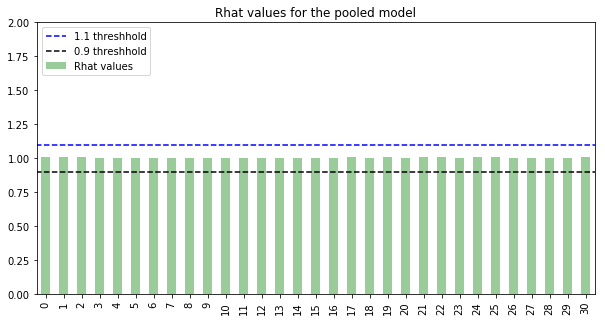

In [15]:
summary = pooled_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

Rhat = summary['Rhat'].values

pd.Series(Rhat).plot(kind='bar', color='green', label='Rhat values', alpha=0.4)
plt.title('Rhat values for the pooled model')
plt.hlines(1.1, -1, 31, label='1.1 threshhold', linestyles='dashed', color='blue')
plt.hlines(0.9, -1, 31, label='0.9 threshhold', linestyles='dashed')
plt.ylim(0, 2)
plt.legend(loc='upper left')
plt.show()

From the histogram above, we can see that all the Rhat values are in a range between 0.9 and 1.1, which means that the model <b>has converged</b>.

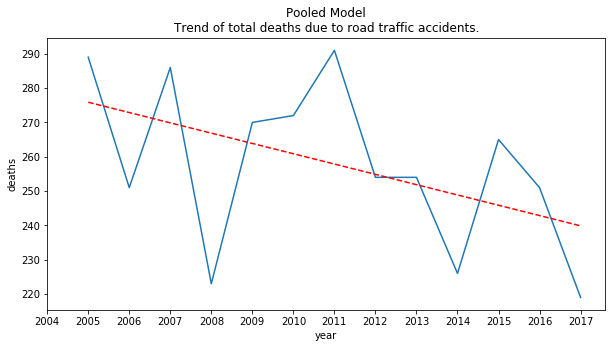

In [16]:
alpha = pooled_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = pooled_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, total_deaths)
plt.plot(years, [alpha + beta * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Pooled Model\nTrend of total deaths due to road traffic accidents.')
plt.show()

In [17]:
def get_PSIS_LOO(model):
    """
    Get logposterior from the model, excluding the warmup perid
    Calculate the effective number of parameters p_eff
    Return PSIS-LOO estimates, p_eff
    """
    log_lik = model.extract(permuted=True)['log_lik']
    psis_loo, psis_loos_sep, k_values = psisloo(log_lik)
    
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0)))
    p_eff = lppd - psis_loo
    
    return psis_loo, psis_loos_sep, k_values, p_eff

def quality_analysis(model):
    """
    Plots the resulting k_values
    """
    psis_loo, psis_loos_sep, k_values, p_eff = get_PSIS_LOO(model)
    
    print('PSIS-LOO estimate: {:.2f}\np_eff value: {:.2f}'.format(psis_loo, p_eff))
    
    pd.Series(k_values).plot(kind='bar', color='green', label='k-values', alpha=0.4)
    plt.title('K-values < 0.7: {0} out of {1}'.format(sum(k_values <= .7), len(k_values)))
    plt.hlines(0.7, -1, 30, label='0.7 threshhold', linestyles='dashed')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

PSIS-LOO estimate: -61.12
p_eff value: 2.50


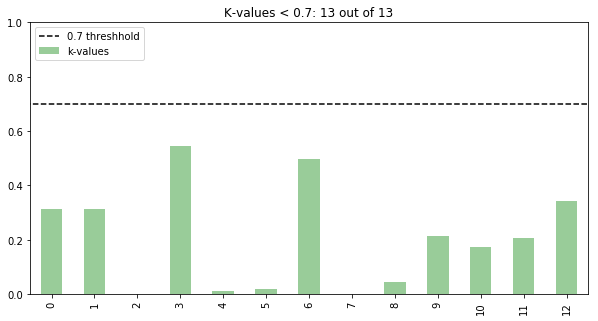

In [18]:
quality_analysis(pooled_fit)

### PSIS - LOO value

The pooled model has PSIS-LOO value of <b>-61.03</b>

From the histogram above, we can see that all the <b>K</b> values are below the threshold of 0.7, which means that the PSIS-LOO value can be considered to be reliable.

### Posterior Predictions for 2018

In [37]:
print('Total number of deaths in 2018:  \t {0}'.format( 
    round(np.mean(pooled_fit.extract()['new_pred']))) 
)

Total number of deaths in 2018:  	 236.0


In [19]:
def plot_prediction_histogram(fit, xlim, xticks, bins, title='', ypred='new_pred'):
    y_pred = fit.extract()[ypred]
    plt.hist(y_pred, bins=bins, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(np.arange(xlim[0], xlim[1], xticks))
    plt.title(title)
    plt.show()

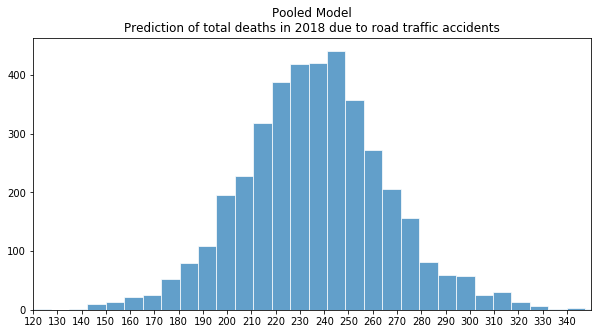

In [20]:
plot_prediction_histogram(
    pooled_fit, 
    ypred='new_pred',
    xlim=[120, 350], 
    xticks=10, 
    bins=40,
    title='Pooled Model\nPrediction of total deaths in 2018 due to road traffic accidents'
)

### Prior sensitivity analysis for pooled model

The pooled model that we currently have has a weakly informative prior.
Now we can try to use a uniform prior and see how sensitive our pooled model is to the prior.

Below is the Stan code for the pooled model with a uniform prior.

In [21]:
pooled_code_uniform = '''
data {
    int<lower=0> N;                 // number of data points
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
    real tau;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = alpha + (beta * years);
    
}

model {
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma);
}

generated quantities {
    real new_pred;
    vector[N] log_lik;
    
    new_pred = normal_rng(alpha + beta * xpred, sigma);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma);
}
'''

The only thing that we had to change in our model was to remove the line: <b>beta ~ normal(0, tau);</b>.
<br>
Now our model has a uniform prior.
<br>
Due to avoiding code redundancy, we are not including the model fitting and sampling for the pooled model with uniform prior.
<br>
From the results that we have gotten, we have noticed that the model does not change almost at all if we use uniform instead of a weakly informative prior.
<br>
From that we can come to a conclusion that the pooled model has very <b>low prior sensitivity</b>.

## Separate Model

This model will tell us explicitely the number of deaths of male and female, but it won't tell us about the total number of deaths as the Pooled model did. The whole idea behind this model is that it treats the each category as a separate entity and it will not combine all the measurments into one set of data.

The parameters that this model takes is similar to Pooled model:
* *N*: Total number of deaths 
* *K*: The number of groups, which are male and female
* *group[N]*: Is an array that indicates to which group the data belongs. The data that it takes is in the form of `[1,1,1,2,2,2]`, meaning that the firs 3 elements belong to the first group and the second three elements belong to the second group. 
* *xpred*: the year we wont to predict
* *number_of_deaths*: number of deaths passed as an array
* *years*: list of the years passed as an array
* *tau*: $\tau$ is used for weekly informative prior like: `beta ~ normal(0, tau)`. If we don't include it then our prior would be uniform. In this model we have two $\tau$ as our data is categorized into male and female. 

As in Pooled model, we transform $\mu$ as we are using regression. Further we predict the number of death for the future by creating `male_pred` and `female_pred`. The `log_lik` is again used later for evaluation of the model.

In [22]:
# SEPARATE MODEL
separate_code = '''
data {
    int<lower=0> N;                 // number of data points
    int<lower=0> K;                 // number of groups
    int<lower=1,upper=K> group[N];  // group indicator
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years; 
    vector[K] tau;
}

parameters {
    vector[K] alpha;
    vector[K] beta;
    vector<lower=0>[K] sigma;
}

transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[group[i]] + beta[group[i]] * years[i];
}

model {
    beta[1] ~ normal(0, tau[1]);
    beta[2] ~ normal(0, tau[2]); 
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma[group[i]]);
}

generated quantities {
    real male_pred;
    real female_pred;
    vector[N] log_lik;

    male_pred = normal_rng(alpha[1] + beta[1] * xpred, sigma[1]);
    female_pred = normal_rng(alpha[2] + beta[2] * xpred, sigma[2]);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[group[i]]);
}
'''

sm = pystan.StanModel(model_code = separate_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2540ac1bb6c4020a6657c7d23ffd014 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmpsgdgs91w/stanfit4anon_model_d2540ac1bb6c4020a6657c7d23ffd014_987832916840099149.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [23]:
accidents_data = {
    'N': N,
    'K': num_groups,
    'group': x,
    'number_of_deaths': combined,
    'years': list(years)*2,
    'xpred': 2018,
    'tau': [male_tau, female_tau]
}

In [24]:
separate_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

### How Stan code is run

The Stan code for the separate model is configured the same way as the pooled model.
<br>
It has <b>4 chains</b> and each of those chains has <b>2000 iterations</b>.
<br>
<b>1000 samples</b> are discarded as a burnout.
<br><br>
In order to control the sampler's behavior, we have set: <b>'adapt_delta': 0.95</b> and <b>'max_treedepth': 15</b>

### Separate model evaluation

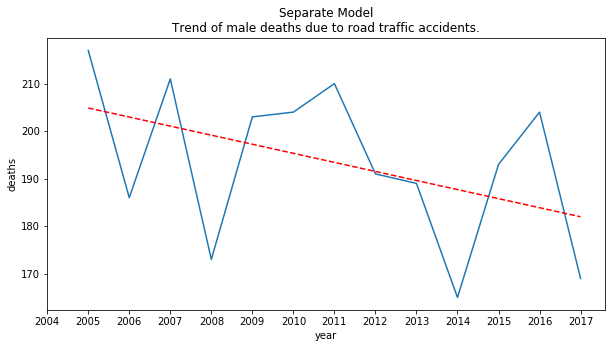

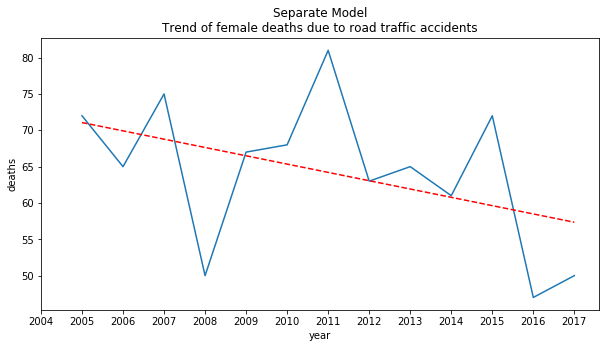

In [25]:
alpha = separate_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = separate_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, male)
plt.plot(years, [alpha[0] + beta[0] * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of male deaths due to road traffic accidents.')
plt.show()

plt.plot(years, female)
plt.plot(years, [alpha[1] + beta[1] * i for i in range(2005, 2018)], 'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of female deaths due to road traffic accidents')
plt.show()

PSIS-LOO estimate: -106.49
p_eff value: 4.70


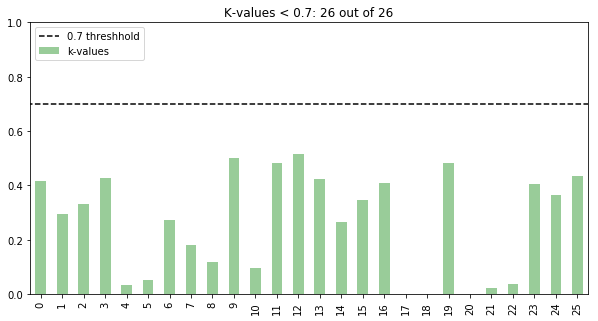

In [26]:
quality_analysis(separate_fit)

### PSIS - LOO value

The separate model has PSIS-LOO value of <b>-106.80</b>

From the histogram above, we can see that all the <b>K</b> values are below the threshold of 0.7, which means that the PSIS-LOO value can be considered to be reliable.

### Posterior Predictions for 2018

In [36]:
print('Prediction of male deaths in 2018:  \t {0}'.format( 
    round(np.mean(separate_fit.extract()['male_pred']))) 
 )
print('Prediction of female deaths in 2018:\t {0}'.format( 
    round(np.mean(separate_fit.extract()['female_pred']))) 
 )

Prediction of male deaths in 2018:  	 180.0
Prediction of female deaths in 2018:	 56.0


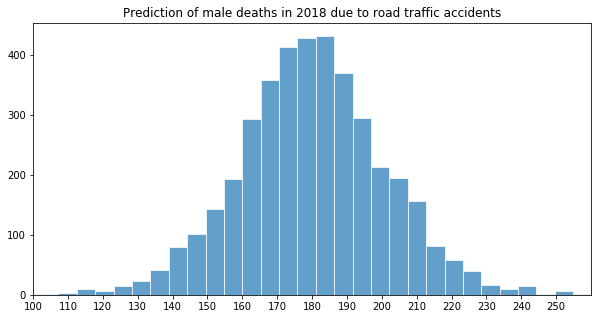

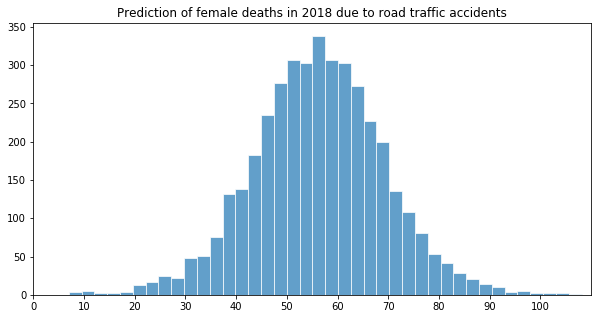

In [27]:
plot_prediction_histogram(
    separate_fit, 
    ypred='male_pred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Prediction of male deaths in 2018 due to road traffic accidents'
)

plot_prediction_histogram(
    separate_fit, 
    ypred='female_pred',
    xlim=[0, 110], 
    xticks=10, 
    bins=40,
    title='Prediction of female deaths in 2018 due to road traffic accidents'
)

### Model summary

In [33]:
get_model_summary(separate_fit)

PSIS-LOO value: -106.49402540217122
The effective number of parameters is: 4.696456283555946
K-hat values: [ 0.41431451  0.29458923  0.33133198  0.42814818  0.03295941  0.05097649
  0.27328364  0.18117908  0.11934412  0.50149424  0.09740807  0.48369531
  0.51666048  0.42308081  0.26412348  0.34489682  0.40674083 -0.03455629
 -0.04556539  0.48377368 -0.02465552  0.02317673  0.03792426  0.403642
  0.36450702  0.43369512]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[1],4030.689382,75.956830,2774.887613,-1335.825685,2293.541832,4027.108356,5677.411467,9759.539203,1334.618481,1.000467
alpha[2],2363.456106,50.176524,1665.999191,-1027.213382,1395.178578,2356.600958,3350.628302,5697.773320,1102.423427,1.000313
beta[1],-1.908137,0.037773,1.379843,-4.756298,-2.726973,-1.905993,-1.046298,0.761439,1334.408659,1.000468
beta[2],-1.143336,0.024950,0.828434,-2.801561,-1.633837,-1.139162,-0.661464,0.542745,1102.451416,1.000313
sigma[1],18.077336,0.117508,4.535767,11.642880,14.863057,17.262829,20.498753,28.533033,1489.935158,1.003592
sigma[2],10.885385,0.066132,2.606144,7.077562,9.038018,10.487346,12.212500,17.299312,1552.989820,1.001491
mu[1],204.873747,0.233734,9.795480,185.410777,198.589026,204.783225,211.101411,224.763026,1756.337905,1.000032
mu[2],202.965609,0.198712,8.657673,185.806612,197.441672,202.928742,208.347785,220.531578,1898.244205,0.999963
mu[3],201.057472,0.165381,7.600467,186.019864,196.252457,201.047771,205.756658,216.687945,2112.086368,0.999882
mu[4],199.149335,0.134619,6.662343,186.088049,194.946365,199.182872,203.203248,212.676897,2449.312842,0.999795


### Convergence diagnostics for the separate model

From the histogram above, we can see that all the Rhat values are in a range between 0.9 and 1.1, which means that the model <b>has converged</b>.

### Prior sensitivity analysis for separate model

The separate model that we currently have has a weakly informative prior.
Now we can try to use a uniform prior and see how sensitive our separate model is to the prior.

Below is the Stan code for the separate model with a uniform prior.

In [30]:
separate_code_uniform = '''
data {
    int<lower=0> N;                 // number of data points
    int<lower=0> K;                 // number of groups
    int<lower=1,upper=K> group[N];  // group indicator
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years; 
    vector[K] tau;
}

parameters {
    vector[K] alpha;
    vector[K] beta;
    vector<lower=0>[K] sigma;
}

transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[group[i]] + beta[group[i]] * years[i];
}

model {
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma[group[i]]);
}

generated quantities {
    real male_pred;
    real female_pred;
    vector[N] log_lik;

    male_pred = normal_rng(alpha[1] + beta[1] * xpred, sigma[1]);
    female_pred = normal_rng(alpha[2] + beta[2] * xpred, sigma[2]);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[group[i]]);
}
'''

The only thing that we had to change in our model was to remove the lines: <b>beta[1] ~ normal(0, tau[1]);</b> and <b>beta[2] ~ normal(0, tau[2]); </b>
<br>
Now our model has a uniform prior.
<br>
Due to avoiding code redundancy, we are not including the model fitting and sampling for the separate model with uniform prior.
<br>
From the results that we have gotten, we have noticed that the model does not change almost at all if we use uniform instead of a weakly informative prior.
<br>
From that we can come to a conclusion that the separate model has very <b>low prior sensitivity</b>.

# Model comparison

From the calculated PSIS-LOO values, we can see that the pooled model has PSIS-LOO value of <b>-61.03</b>, compared to the separate model, which has PSIS-LOO value of <b>-106.80</b>. Since all of the <b>K</b> values, stated above, are below the threshold of 0.7, we can conclude that the PSIS-LOO values are reliable. 

Even though the PSIS-LOO tells how good or bad a model is, these two models in our case should not be compared against each other. The reason is that they are ment for different computations. With the Pooled model we can calculate the total number of deaths, but the model does not compute the exact number of deaths for male or female. The Separate model on the other hand, computes the number of death for male and female separately, but it does not calculate the total number of deaths. Consequently, comparing them to each other is not a very rational option. 

# Discussion of problems and potential improvements

The current project needs improvements in some areas. One of which is categorizing the death rates by age. For instance, at the moment the number of deaths are classified as male or female and there is no any information about the age. Clarifying the age more specifically, will lead to indepth observations of the age category that could tell the age range of individuals that have the highest rates of death both for male and female.

The second improvement to this project could be creating Hierarchical Model and then comparing its computations to both Separate and Pooled model.

# Appendices

## Requirements 

#### Based on TA's suggestion
- [x] pooled model
- [x] separate model
- [x] predictions
- [x] loo
- [x] different prior, noninformative, change the prior? why did you select?
- [x] sensitivity analysis, (change the prior)

#### Based on Aki suggestion
- [x] Description of the data, and the analysis problem
- [x] Description of the model
- [x] Description of the prior choices
- [x] Stan code
- [x] How Stan model is run (Number of chains and etc)
- [x] Convergence diagnostics (Rhat, divergences, neff)
- [x] Posterior predictive checking
- [x] Model comparison (e.g. with loo)
- [x] Potentially sensitivity analysis
- [x] Discussion of problems, and potential improvements


#### Based on Rubrics
Is there an introduction?
- [x] The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.

Is there a conclusion?
- [ ] The conclusion is clear

The structure and organization of the notebook
- [x] The notebook presents a clear cohesive data analysis story, which is enjoyable to read

Accuracy of use of statistical terms
- [x] Statistical terms are used accurately and with clarity

Description of the data, and the analysis problem
- [x] Did you get a sense of what is the data and the analysis problem when they were first
introduced? Where and how might the author make the model description more clear?

Description of the model
- [x] Did you get a sense of what is the model? Where and how might the author make the model description more clear?

Description of the prior choices
- [x] Priors are listed and justified

Is Stan code included?
- [x] yes

Is code for how Stan model is run included?
- [x] yes

Is required convergence diagnostics (Rhat, divergences, neff) included?
- [x] Required convergence diagnostic results shown and maning of the results is discussed

Is there posterior predictive checking? 
- [x] yes

Is there a discussion of problems and potential improvements ?
- [x] yes